In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
trisoPkFrac = 0.3
pebblePkFrac = 0.64

reflctThickness = 66;

erchPercent = range(5,21)
U_form = 1;
O_form = 2;
rho_fuel = 10.96; # g/cm3

trisoPartThicknesses = [253.5, 97.7, 41.9, 37.5, 45.6]; #um

coolTemp = 450+273.15 #C -> K
coolPres = 8 #MPa

In [3]:
#      Buffer
buffer = openmc.Material(name='Buffer')
buffer.set_density('g/cm3', 1.0)
buffer.add_element('C', 1.0)
#buffer.add_s_alpha_beta('c_Graphite')

#      IPyC
IPyC = openmc.Material(name='IPyC')
IPyC.set_density('g/cm3', 1.9)
IPyC.add_element('C', 1.0)
#IPyC.add_s_alpha_beta('c_Graphite')

#      SiC
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

#      OPyC
OPyC = openmc.Material(name='OPyC')
OPyC.set_density('g/cm3', 1.87)
OPyC.add_element('C', 1.0)
#OPyC.add_s_alpha_beta('c_Graphite')

# Moderator
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
#graphite.add_s_alpha_beta('c_Graphite')

# Coolant
He = openmc.Material(name='He')
He.set_density('g/cm3',coolPres/coolTemp/2.0771)
He.add_element('He',1.0)
He.temperature = coolTemp

# Reflector
Refl = openmc.Material(name='Reflector')
Refl.set_density('g/cm3',1.72)
Refl.add_element('C',1.0)
Refl.add_s_alpha_beta('c_Graphite')


In [4]:
#B5
trisoPartRads = trisoPartThicknesses
for i in range(1,5):
    trisoPartRads[i] += trisoPartRads[i-1]
trisoPartVolFracs = trisoPartRads
for i in range(5):
    trisoPartVolFracs[i] = (trisoPartRads[i]/trisoPartRads[4])**3
for i in range(4):
    trisoPartVolFracs[4-i] -= trisoPartVolFracs[3-i]
    


In [5]:
#B6
pebbleRads = [25, 30]
pebbleVolFracs = pebbleRads
for i in range(2):
    pebbleVolFracs[i] = (pebbleRads[i]/pebbleRads[1])**3
pebbleVolFracs[1] -= pebbleVolFracs[0]

In [6]:
trisoPkFrac = range(30,60,2)
erchPercent = .1975

In [7]:
#      Fuel Kernel
fuel = openmc.Material(name="fuel")
fuel.set_density('g/cm3', rho_fuel)
fuel.add_nuclide('U235',erchPercent*U_form/(U_form+O_form))
fuel.add_nuclide('U238',((1-erchPercent)*U_form/(U_form+O_form)))
fuel.add_element('O', O_form/(U_form+O_form))
homogTrisoPart = openmc.Material.mix_materials([fuel, buffer, IPyC, SiC, OPyC], trisoPartVolFracs, 'vo')

In [8]:
#Enrichment Optimization
k_eff_tPkFrac = []
kitPF = []
for eki in trisoPkFrac:
    #B4
    homogTrisoPebCore = openmc.Material.mix_materials([homogTrisoPart,graphite], [eki/100, 1-eki/100], 'vo');
    homogTrisoPebble = openmc.Material.mix_materials([homogTrisoPebCore, graphite], pebbleVolFracs, 'vo');


    #B7
    homogCore = openmc.Material.mix_materials([homogTrisoPebble, He], [pebblePkFrac, 1-pebblePkFrac], 'vo')
    homogCore.add_s_alpha_beta('c_Graphite')
    materials = openmc.Materials()
    materials += [Refl, homogCore]
    materials.export_to_xml()
    
        #B8
    core = openmc.model.RightCircularCylinder([0,0,0], 125, 50, axis='z', boundary_type = 'transmission')
    rflctr = openmc.model.RightCircularCylinder([0,0,-reflctThickness],2*reflctThickness+125,reflctThickness+50, axis ='z',boundary_type = 'vacuum') 
    rxr = openmc.Cell(fill=homogCore, region=-core)
    reflect = openmc.Cell(fill = Refl, region =+core&-rflctr)
    surr = openmc.Cell(region =+rflctr)
    universe = openmc.Universe(cells=[rxr, reflect, surr])
    geometry = openmc.Geometry()
    geometry.root_universe = universe
    geometry.export_to_xml()
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue'
    settings.particles = 25000
    settings.batches = 45
    settings.inactive = 15
    settings.temperature={'method':'interpolation','range':(250,2500)}
    settings.export_to_xml()

    

    #B9
    num_threads_des = 136  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
    num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS
    
    openmc.run(threads = num_threads, output=True)
    sp = openmc.StatePoint('statepoint.45.h5')
    keff = sp.keff
    k_eff_tPkFrac.append(keff.n)
    kitPF.append(keff.s)
    sp.close()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

<ErrorbarContainer object of 3 artists>

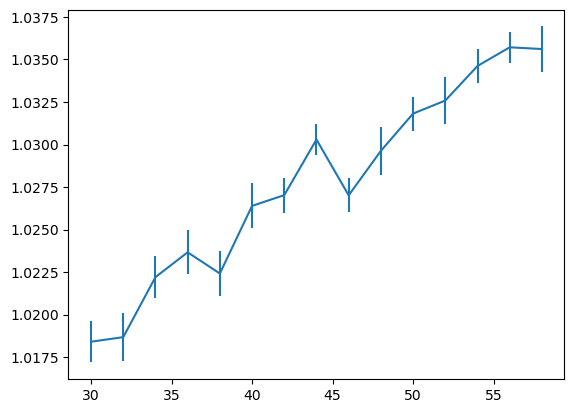

In [9]:
plt.errorbar(np.array(trisoPkFrac), np.array(k_eff_tPkFrac),np.array(kitPF))